In [1]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from src.models import Coordinates
from src.models import Request  # Датакласс для входных данных
from typing import List, Callable
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np

moscow = Coordinates(55.75222, 37.61556)
ekaterenburg = Coordinates(56.838008, 60.597452)

NUM_COURIERS = 5  # Кол-во курьеров

In [2]:
r = Request.from_txt("data/input1.txt")

print(f'Capacity: {r.capacity}\nTime limit: {r.time}\nTotal points: {r.points_number}')


Capacity: 50
Time limit: 29591
Total points: 656


In [3]:
import folium
from typing import List
from typing import Optional
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import itertools


from src.models import Request


def GeoMap(
    r: Request, route: Optional[List[int]] = None, rote_only: bool = True
) -> folium.Map:
    M = folium.Map(location=reversed(list(r.center)), zoom_start=11)

    for i, point in enumerate(r.scooters):
        if i == 0:
            color = "darkred"
        elif route and i in route:
            color = "green"
        else:
            color = "blue"
        if not rote_only or i in route:
            folium.Marker(
                location=[point.lat, point.lon],
                icon=folium.Icon(icon="star", color=color),
            ).add_to(M)
    if route:
        folium.PolyLine(
            locations=[list(r.scooters[i]) for i in route],
            color="red",
            weight=15,
            opacity=0.8,
        ).add_to(M)

    return M


def get_color_palette(num_colors: int) -> List[str]:
    colors = plt.get_cmap("tab20", num_colors).colors
    return [matplotlib.colors.rgb2hex(color) for color in colors]


colours = [
    "darkpurple",
    "red",
    "lightgray",
    "darkblue",
    "cadetblue",
    "gray",
    "beige",
    "blue",
    "black",
    "lightred",
    "darkred",
    "pink",
    "orange",
    "green",
    "lightblue",
    "white",
    "purple",
    "darkgreen",
    "lightgreen",
]


def GeoMap_Routes(
    r: Request, routes: List[List[int]] = None, rote_only: bool = False
) -> folium.Map:
    M = folium.Map(location=list(r.center), zoom_start=11)
    route_colors = get_color_palette(len(routes)) if routes else []
    for route, color_route, color in zip(routes, itertools.cycle(route_colors), itertools.cycle(colours)
):
        folium.PolyLine(
            locations=[[r.scooters[i].lat, r.scooters[i].lon] for i in route],
            color=color_route,
            weight=15,
            opacity=0.8,
        ).add_to(M)
        for i in route:
            folium.Marker(
                location=[r.scooters[i].lat, r.scooters[i].lon],
                icon=folium.Icon(icon="star", color=color),
            ).add_to(M)

    return M


## Жадный алгоритм

In [4]:

def greedy_algorithm(request: Request, num_couriers: int) -> List[List[int]]:
    scooters = request.scooters
    time_matrix = request.time_matrix
    capacity = request.capacity
    time_limit = request.time

    couriers_routes = [[] for _ in range(num_couriers)]
    scooters_indices = set(range(1, len(scooters))) 
    for courier in range(num_couriers):
        route = [0] 
        time_used = 0

        while scooters_indices and len(route) - 1 < capacity:
            last = route[-1]
            next_scooter = min(scooters_indices, key=lambda i: time_matrix[last][i])
            if time_used + time_matrix[last][next_scooter] > time_limit:
                break
            route.append(next_scooter)
            time_used += time_matrix[last][next_scooter]
            scooters_indices.remove(next_scooter)

        route.append(0)
        couriers_routes[courier] = route

    return couriers_routes


In [19]:
GeoMap_Routes(r, routes=greedy_algorithm(r, num_couriers=NUM_COURIERS))


In [6]:
def calculate_total_cost(request: Request, routes: List[List[int]]) -> float:
    return sum(request.score(route) for route in routes)

# Генетический алгоритм

In [7]:
import random

def genetic_algorithm(request: Request, num_couriers: int, population_size: int, generations: int, mutation_rate: float) -> List[List[int]]:
    def initial_population():
        population = []
        for _ in range(population_size):
            routes = [[] for _ in range(num_couriers)]
            for i in range(1, len(request.scooters)):
                courier = i % num_couriers
                routes[courier].append(i)
            for route in routes:
                route.insert(0, 0)
                route.append(0)
            population.append(routes)
        return population

    def total_score(routes):
        return sum(request.score(route) for route in routes)

    def crossover(parent1, parent2):
        child = [[] for _ in range(num_couriers)]
        for i in range(num_couriers):
            if random.random() < 0.5:
                child[i] = parent1[i][:]
            else:
                child[i] = parent2[i][:]
        return child

    def mutate(routes):
        for route in routes:
            if random.random() < mutation_rate and len(route) > 2:
                i, j = random.sample(range(1, len(route) - 1), 2)
                route[i], route[j] = route[j], route[i]
        return routes

    def enforce_capacity(routes):
        for route in routes:
            if len(route) - 2 > request.capacity:
                while len(route) - 2 > request.capacity:
                    excess_node = route.pop(random.randint(1, len(route) - 2))
                    for r in routes:
                        if len(r) - 2 < request.capacity:
                            r.insert(random.randint(1, len(r) - 1), excess_node)
                            break
        return routes

    population = initial_population()
    for generation in range(generations):
        population = [enforce_capacity(individual) for individual in population]
        population = sorted(population, key=total_score, reverse=True)
        new_population = population[:population_size // 2]
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(population[:population_size // 2], 2)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)
        population = new_population

    best_solution = max(population, key=total_score)
    return best_solution

def run_genetic_algorithm_optimization(request: Request, num_couriers: int):
    '''
        Поиск оптимальных значений для параметров генетического алгоритма
    '''
    population_size_values = [30, 50, 70]
    generations_values = [50, 100, 150, 700, 1000]
    mutation_rate_values = np.linspace(0.005, 0.3, 10)

    best_params = None
    best_cost = float('inf')

    for population_size, generations, mutation_rate in itertools.product(population_size_values, generations_values, mutation_rate_values):
        routes = genetic_algorithm(request, num_couriers, population_size, generations, mutation_rate)
        total_cost = calculate_total_cost(request, routes)
        if total_cost < best_cost:
            best_cost = total_cost
            best_params = (population_size, generations, mutation_rate)

    print(f"Best Parameters for Genetic Algorithm: Population Size={best_params[0]}, Generations={best_params[1]}, Mutation Rate={best_params[2]}")
    print(f"Best Cost: {best_cost}")

    return best_params, best_cost

# run_genetic_algorithm_optimization(r, num_couriers=NUM_COURIERS)
# Best Parameters for Genetic Algorithm: Population Size=30, Generations=50, Mutation Rate=0.005
# Best Cost: 573250.0


In [8]:
GeoMap_Routes(r, routes= genetic_algorithm(r, num_couriers=3, population_size=100, generations=1000, mutation_rate=0.4))


# Алгоритм отжига

In [9]:
import random
import math



def simulated_annealing(request: Request, num_couriers: int, initial_temp: float, cooling_rate: float, num_iterations: int) -> List[List[int]]:
    def initial_solution():
        routes = [[] for _ in range(num_couriers)]
        for i in range(1, len(request.scooters)):
            courier = i % num_couriers
            routes[courier].append(i)
        for route in routes:
            route.insert(0, 0)
            route.append(0)
        return routes

    def total_score(routes):
        return sum(request.score(route) for route in routes)

    def get_neighbor(routes):
        new_routes = [route[:] for route in routes]
        while True:
            route_idx = random.randint(0, num_couriers - 1)
            if len(new_routes[route_idx]) > 2:
                break
        i, j = random.sample(range(1, len(new_routes[route_idx]) - 1), 2)
        new_routes[route_idx][i], new_routes[route_idx][j] = new_routes[route_idx][j], new_routes[route_idx][i]
        return new_routes

    def enforce_capacity(routes):
        for route in routes:
            if len(route) - 2 > request.capacity:
                while len(route) - 2 > request.capacity:
                    excess_node = route.pop(random.randint(1, len(route) - 2))
                    for r in routes:
                        if len(r) - 2 < request.capacity:
                            r.insert(random.randint(1, len(r) - 1), excess_node)
                            break
        return routes

    current_solution = initial_solution()
    current_solution = enforce_capacity(current_solution)
    current_score = total_score(current_solution)
    best_solution = current_solution[:]
    best_score = current_score
    temperature = initial_temp

    for _ in range(num_iterations):
        neighbor_solution = get_neighbor(current_solution)
        neighbor_solution = enforce_capacity(neighbor_solution)
        neighbor_score = total_score(neighbor_solution)
        if neighbor_score > current_score or math.exp((neighbor_score - current_score) / temperature) > random.random():
            current_solution = neighbor_solution
            current_score = neighbor_score
            if current_score > best_score:
                best_solution = current_solution
                best_score = current_score
        temperature *= cooling_rate

    return best_solution

import itertools
import numpy as np


def run_simulated_annealing_optimization(request: Request, num_couriers: int):
    '''
        Поиск оптимальных значений для параметров алгоритма отжига
    '''
    initial_temp_values = np.linspace(500.0, 1500.0, 10)
    cooling_rate_values = np.linspace(0.85, 0.99, 10)
    num_iterations_values = [500, 1000, 1500]

    best_params = None
    best_cost = float('inf')

    for initial_temp, cooling_rate, num_iterations in itertools.product(initial_temp_values, cooling_rate_values, num_iterations_values):
        routes = simulated_annealing(request, num_couriers, initial_temp, cooling_rate, num_iterations)
        total_cost = calculate_total_cost(request, routes)
        if total_cost < best_cost:
            best_cost = total_cost
            best_params = (initial_temp, cooling_rate, num_iterations)

    print(f"Best Parameters for Simulated Annealing: Initial Temp={best_params[0]}, Cooling Rate={best_params[1]}, Num Iterations={best_params[2]}")
    print(f"Best Cost: {best_cost}")

    return best_params, best_cost


# run_simulated_annealing_optimization(r, NUM_COURIERS)

# Best Parameters for Simulated Annealing: Initial Temp=1277.7777777777778, Cooling Rate=0.8966666666666666, Num Iterations=500
# Best Cost: 625266.0


In [10]:
GeoMap_Routes(r, routes= simulated_annealing(r, num_couriers=3, initial_temp=100, cooling_rate=0.99, num_iterations=100000))

In [11]:
r = Request.from_txt("data/input4.txt")
r.move_to(ekaterenburg)

def run_algorithm(algorithm: Callable, *args) -> List[List[int]]:
    return algorithm(*args)

def calculate_total_cost(request: Request, routes: List[List[int]]) -> float:
    return sum(request.score(route) for route in routes)


## VRP SOLVER

In [12]:
def create_data_model(request: Request, num_couriers):
    """Stores the data for the problem."""
    data = {}
    data['time_matrix'] = request.time_matrix
    data['num_vehicles'] = num_couriers
    data['depot'] = 0
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route_distance = 0
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        route.append(manager.IndexToNode(index))
        routes.append(route)
        total_distance += route_distance
    return routes

def solve_vrp(request: Request, num_couriers: int):
    data = create_data_model(request, num_couriers)
    
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']), data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Time constraint.
    dimension_name = 'Time'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        request.time,  # vehicle maximum travel time
        True,  # start cumul to zero
        dimension_name)
    time_dimension = routing.GetDimensionOrDie(dimension_name)
    time_dimension.SetGlobalSpanCostCoefficient(100)

    # Set the search parameters.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        routes = print_solution(data, manager, routing, solution)
        return routes
    else:
        print('No solution found !')
        return []

# Сравнение результатов

No solution found !
No solution found !
No solution found !
Objective: 2150002


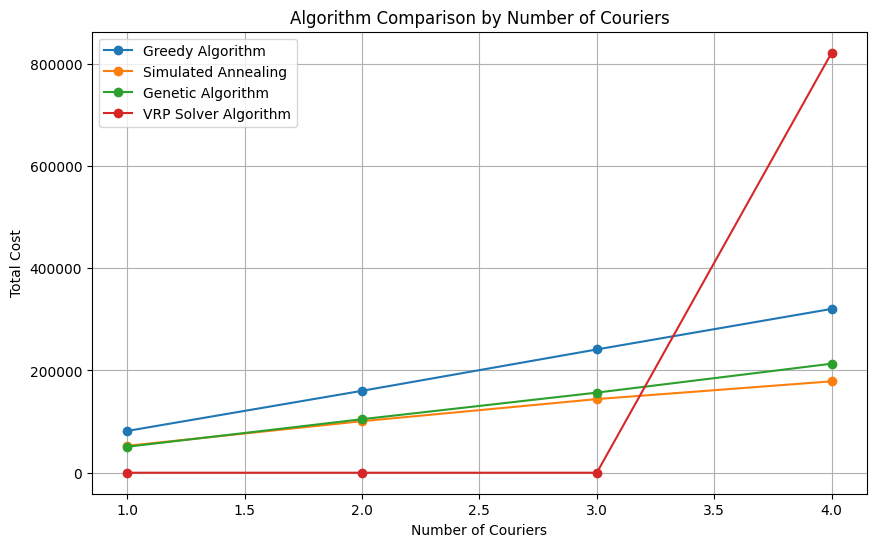

In [13]:
def compare_algorithms(request: Request, courier_range: range):
    initial_temp = 1277.7
    cooling_rate = 0.8966666666666666
    num_iterations = 500
    population_size = 30
    generations = 500
    mutation_rate = 0.05
    
    greedy_costs = []
    sa_costs = []
    ga_costs = []
    vrp_costs  = []
    
    for num_couriers in courier_range:
        # Run Greedy Algorithm
        greedy_routes = greedy_algorithm(request, num_couriers)
        greedy_cost = calculate_total_cost(request, greedy_routes)
        greedy_costs.append(greedy_cost)
        
        # Run Simulated Annealing
        sa_routes = simulated_annealing(request, num_couriers, initial_temp, cooling_rate, num_iterations)
        sa_cost = calculate_total_cost(request, sa_routes)
        sa_costs.append(sa_cost)
        
        # Run Genetic Algorithm
        ga_routes = genetic_algorithm(request, num_couriers, population_size, generations, mutation_rate)
        ga_cost = calculate_total_cost(request, ga_routes)
        ga_costs.append(ga_cost)

        # Run VRP Solver
        vrp_routes = solve_vrp(request, num_couriers)
        vrp_cost  = calculate_total_cost(request, vrp_routes)
        vrp_costs.append(vrp_cost)
    
    return greedy_costs, sa_costs, ga_costs, vrp_costs

def plot_comparison(courier_range: range, greedy_costs: List[float], sa_costs: List[float], ga_costs: List[float], vrp_costs: List[float]):
    plt.figure(figsize=(10, 6))
    plt.plot(courier_range, greedy_costs, label='Greedy Algorithm', marker='o')
    plt.plot(courier_range, sa_costs, label='Simulated Annealing', marker='o')
    plt.plot(courier_range, ga_costs, label='Genetic Algorithm', marker='o')
    plt.plot(courier_range, vrp_costs, label='VRP Solver Algorithm', marker='o')
    
    plt.xlabel('Number of Couriers')
    plt.ylabel('Total Cost')
    plt.title('Algorithm Comparison by Number of Couriers')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparison(range(1,NUM_COURIERS), *compare_algorithms(r, range(1,NUM_COURIERS)))


In [14]:
routes = solve_vrp(r, NUM_COURIERS)


Objective: 2113684


In [15]:
len(routes)

5

In [16]:
GeoMap_Routes(r, routes=routes)

In [17]:
calculate_total_cost(r, routes)


817516.0